In [48]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn

from pyro.infer import MCMC, NUTS
from pyro.infer import Predictive

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split



In [49]:
data = fetch_openml(name="boston", version=1, as_frame=False)
X, y = data.data.astype(float), data.target

x_train, x_test = torch.from_numpy(X[:350,:]).float(), torch.from_numpy(X[350:,:]).float()
y_train, y_test = torch.from_numpy(y[:350]).float(), torch.from_numpy(y[350:]).float()

X.shape

(506, 13)

In [50]:
class BNN(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=10, n_hid_layers=5, prior_scale=5., noise_std=1):
        super().__init__()
        self.in_dim = in_dim
        self.noise_std = noise_std

        self.activation = nn.LeakyReLU(negative_slope=0.1)  # could also be ReLU or LeakyReLU
        assert in_dim > 0 and out_dim > 0 and hid_dim > 0 and n_hid_layers > 0  # make sure the dimensions are valid

        # Define the layer sizes and the PyroModule layer list
        self.layer_sizes = [in_dim] + n_hid_layers * [hid_dim] + [out_dim]
        layer_list = [PyroModule[nn.Linear](self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                      range(1, len(self.layer_sizes))]
        self.layers = PyroModule[torch.nn.ModuleList](layer_list)

        for layer_idx, layer in enumerate(self.layers):
            layer.weight = PyroSample(dist.Normal(0., prior_scale * np.sqrt(2 / self.layer_sizes[layer_idx])).expand(
                [self.layer_sizes[layer_idx + 1], self.layer_sizes[layer_idx]]).to_event(2))
            layer.bias = PyroSample(dist.Normal(0., prior_scale).expand([self.layer_sizes[layer_idx + 1]]).to_event(1))

    def forward(self, x, y=None):
        x = x.reshape(-1, self.in_dim)
        x = self.activation(self.layers[0](x))  # input --> hidden
        for layer in self.layers[1:-1]:
            x = self.activation(layer(x))  # hidden --> hidden
        mu = self.layers[-1](x).squeeze()  # hidden --> output
        sigma = self.noise_std

        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)
        return mu

In [51]:
# Define Hamiltonian Monte Carlo (HMC) kernel
# NUTS = "No-U-Turn Sampler" (https://arxiv.org/abs/1111.4246), gives HMC an adaptive step size
model = BNN(in_dim = X.shape[1], out_dim = 1, hid_dim=4, n_hid_layers=2, prior_scale=5., noise_std=1)

nuts_kernel = NUTS(model, jit_compile=False)  # jit_compile=True is faster but requires PyTorch 1.6+

# Define MCMC sampler, get 50 posterior samples
mcmc = MCMC(nuts_kernel, num_samples=50)
    
# define model and data

# define MCMC sampler
nuts_kernel = NUTS(model, jit_compile=False)
mcmc = MCMC(nuts_kernel, num_samples=250, warmup_steps=100)
mcmc.run(x_train, y_train)


Sample: 100%|██████████| 350/350 [04:14,  1.38it/s, step size=1.27e-04, acc. prob=0.960]


In [52]:
post_samples = mcmc.get_samples()

keys = list(post_samples.keys())
print(keys)

post_samples[keys[1]].shape

['layers.0.bias', 'layers.0.weight', 'layers.1.bias', 'layers.1.weight', 'layers.2.bias', 'layers.2.weight']


torch.Size([250, 4, 13])

In [ ]:
predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
preds = predictive(x_test)['obs']

mse = nn.MSELoss()
mse(preds, y_test)

/Users/patrickgunn/Documents/Documents - iCloud Drive/Uni Fourth Year/Full Year/Group Project/Bayesian-Neural-Network-Project/.venv/lib/python3.9/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([156])) that is different to the input size (torch.Size([250, 156])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(107.4589)

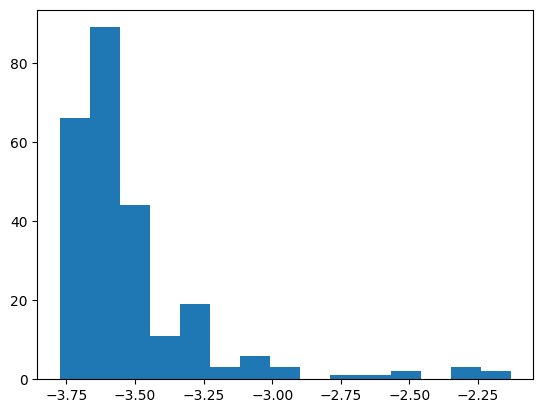

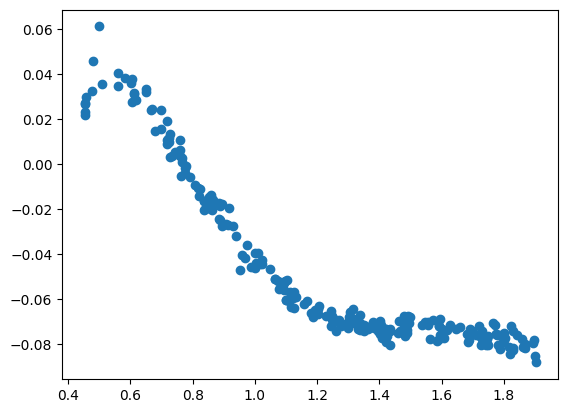

In [ ]:
# MCMC sample for layer 1 weight matrix
l1_weights_sample = mcmc._samples[keys[1]].squeeze(0)  # shape [250,1,4]

w1 = l1_weights_sample[:, 0, 5]
w2 = l1_weights_sample[:, 0, 9]

# plt.hist(w1, bins=15)
# plt.show()
# plt.hist(w3, bins=15)
# plt.show()

plt.scatter(w1, w2)
plt.show()

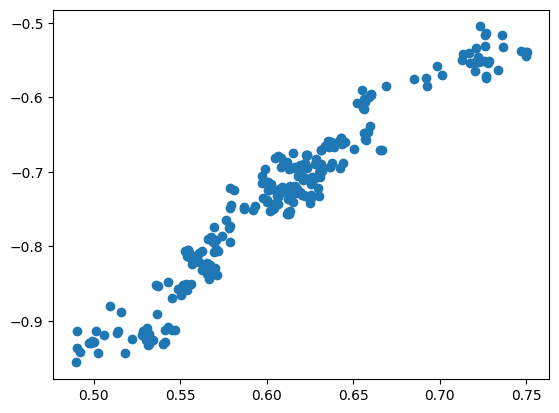

In [95]:
# MCMC sample for layer 2 weight matrix
l2_weights_sample = mcmc._samples[keys[3]].squeeze(0)  # shape [250,4,4]

w1 = l2_weights_sample[:, 1, 0]
w2 = l2_weights_sample[:, 1, 1]

# plt.hist(w1, bins=15)
# plt.show()
# plt.hist(w3, bins=15)
# plt.show()

plt.scatter(w1, w2)
plt.show()